In [1]:
import jax
import os
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np
import scipy

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from genot.models.model import GENOT
from genot.nets.nets import MLP_vector_field, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp
import moscot as mt

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/py

In [2]:
adata_atac = mt.datasets.bone_marrow(rna=False)
adata_rna = mt.datasets.bone_marrow(rna=True)

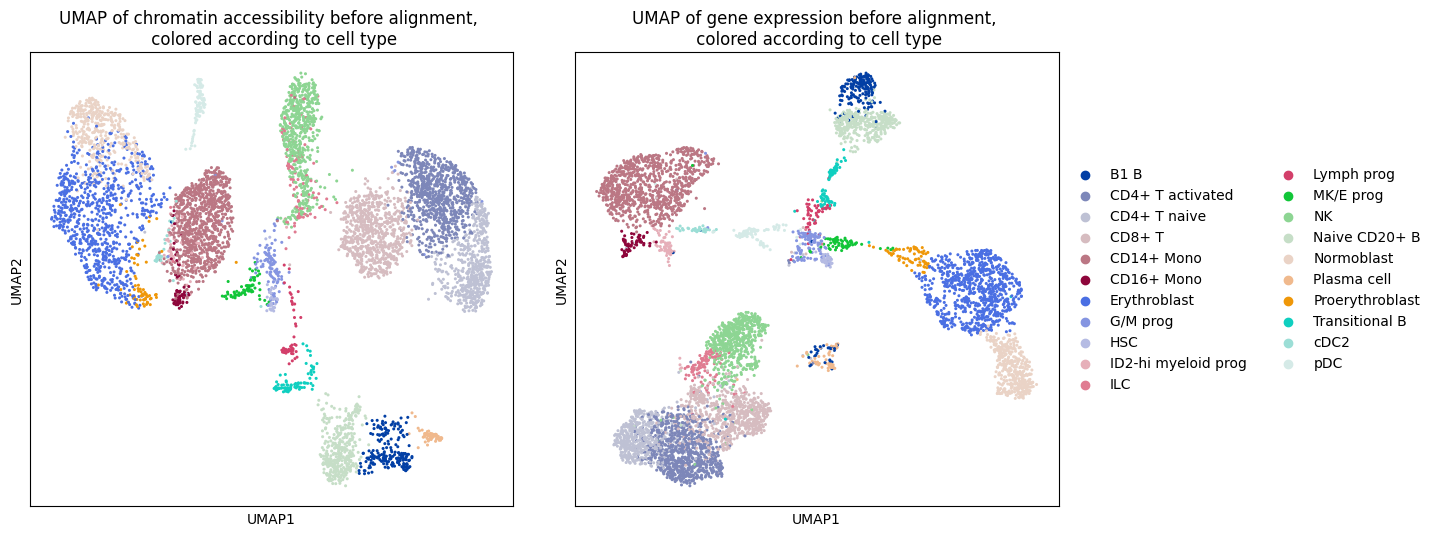

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

# 

In [4]:
adata_source=adata_atac.copy()
adata_target=adata_rna.copy()

n_cells_source=len(adata_atac)

n_samples_train = int(n_cells_source * 0.6)
n_samples_test = n_cells_source - n_cells_source

inds_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train,), replace=False))
inds_test = list(set(list(range(n_cells_source))) - set(np.asarray(inds_train)))

fused = np.concatenate((adata_atac.obsm["geneactivity_scvi"], adata_rna.obsm["geneactivity_scvi"]), axis=0)
fused = sc.pp.pca(fused, n_comps=25)

source_fused = fused[:len(adata_source), :]
target_fused = fused[len(adata_target):, :]

source_q = pp.normalize(
    adata_source.obsm["ATAC_lsi_red"], norm="l2"
) 
target_q = adata_target.obsm["GEX_X_pca"]

source_train_q = source_q[inds_train, :]
source_test_q = source_q[inds_test, :]
target_train_q = target_q[inds_train, :]
target_test_q = target_q[inds_test, :]
source_train_fused = source_fused[inds_train, :]
source_test_fused = source_fused[inds_test, :]
target_train_fused = target_fused[inds_train, :]
target_test_fused = target_fused[inds_test, :]

source_train = np.concatenate((source_train_fused, source_train_q), axis=1)
source_test = np.concatenate((source_test_fused, source_test_q), axis=1)
target_train = np.concatenate((target_train_fused, target_train_q), axis=1)
target_test = np.concatenate((target_test_fused, target_test_q), axis=1)

adata_source_train = adata_source[inds_train,:]
adata_source_test = adata_source[inds_test,:]

adata_target_train = adata_target[inds_train,:]
adata_target_test = adata_target[inds_test,:]

In [5]:
adata_source_train.obsm["emb"] = source_train
adata_source_test.obsm["emb"] = source_test
adata_target_train.obsm["emb"] = target_train
adata_target_test.obsm["emb"] = target_test

adata_source_train.obsm["emb_q"] = source_train_q
adata_source_test.obsm["emb_q"] = source_test_q
adata_target_train.obsm["emb_q"] = target_train_q
adata_target_test.obsm["emb_q"] = target_test_q

adata_source_train.obsm["emb_fused"] = source_train_fused
adata_source_test.obsm["emb_fused"] = source_test_fused
adata_target_train.obsm["emb_fused"] = target_train_fused
adata_target_test.obsm["emb_fused"] = target_test_fused

/tmp/ipykernel_1375382/3633240122.py:1: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_source_train.obsm["emb"] = source_train
/tmp/ipykernel_1375382/3633240122.py:2: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_source_test.obsm["emb"] = source_test
/tmp/ipykernel_1375382/3633240122.py:3: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_target_train.obsm["emb"] = target_train
/tmp/ipykernel_1375382/3633240122.py:4: ImplicitModificationWarning: Setting element `.obsm['emb']` of view, initializing view as actual.
  adata_target_test.obsm["emb"] = target_test


In [6]:
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.01, linear_ot_solver=linear_ot_solver)

genot = GENOT(neural_net, 
              epsilon=None, 
              scale_cost="mean", 
              input_dim=source_train.shape[1], 
              output_dim=target_train.shape[1], 
              iterations=20_000, 
              ot_solver=solver, 
              k_noise_per_x=1, 
              fused_penalty = 1.0, 
              split_dim=fused.shape[1])

In [7]:
genot(source_train, target_train, 1024, 1024)

I0000 00:00:1732110396.750738 1375382 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3257 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:c3:00.0, compute capability: 8.0
100%|██████████| 20000/20000 [24:51<00:00, 13.41it/s] 


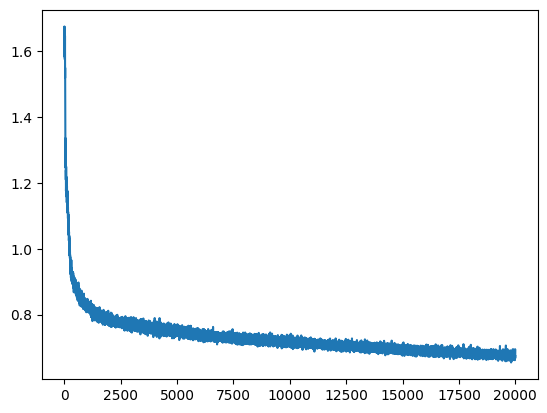

In [8]:
plt.plot(np.arange(len(genot.metrics["loss"])), genot.metrics["loss"])

In [9]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [10]:
res_train = [None] * 30
res_test = [None] * 30

for i in range(30):
    res_train[i] = genot.transport(source_train, seed=i)[0][0,...]
    res_test[i] = genot.transport(source_test, seed=i)[0][0,...]

In [11]:
cond_mean_train = jnp.mean(jnp.asarray(res_train), axis=0)
cond_mean_test = jnp.mean(jnp.asarray(res_test), axis=0)

In [12]:
foscttm(res_train[0], target_train)

0.0916

In [13]:
foscttm(res_test[0], target_test)

0.093

In [14]:
foscttm(cond_mean_train, target_train)

0.0525

In [15]:
foscttm(cond_mean_test, target_test)

0.0537

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


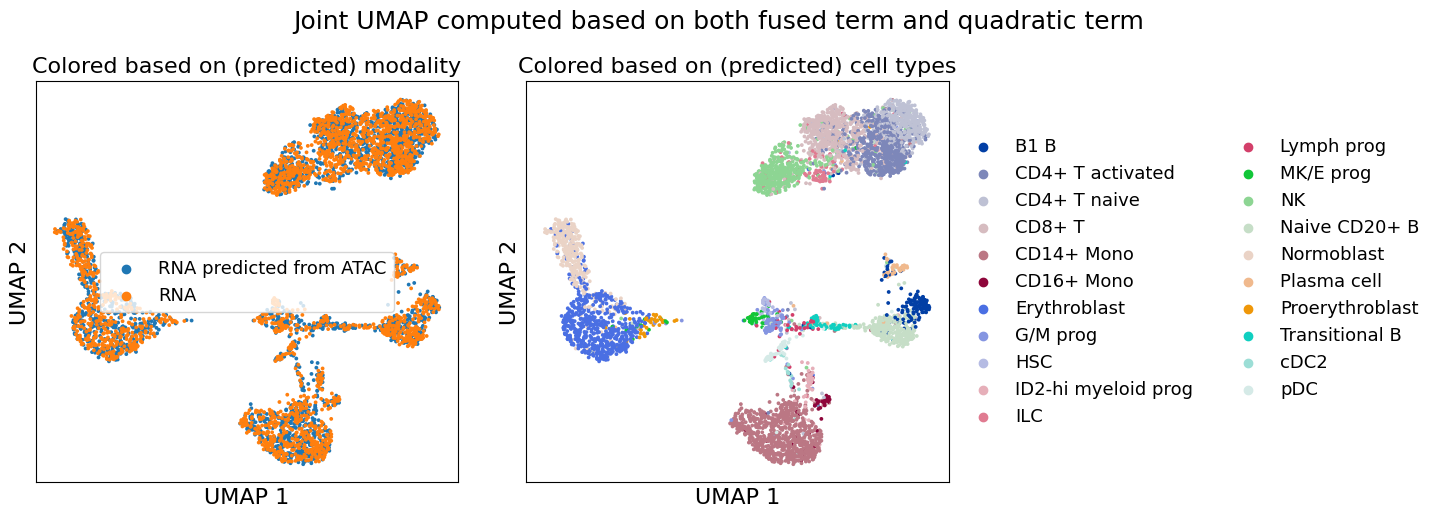

In [16]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_one_sample.obsm["X_translated_0"] = np.concatenate(
    (res_test[0], target_test), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

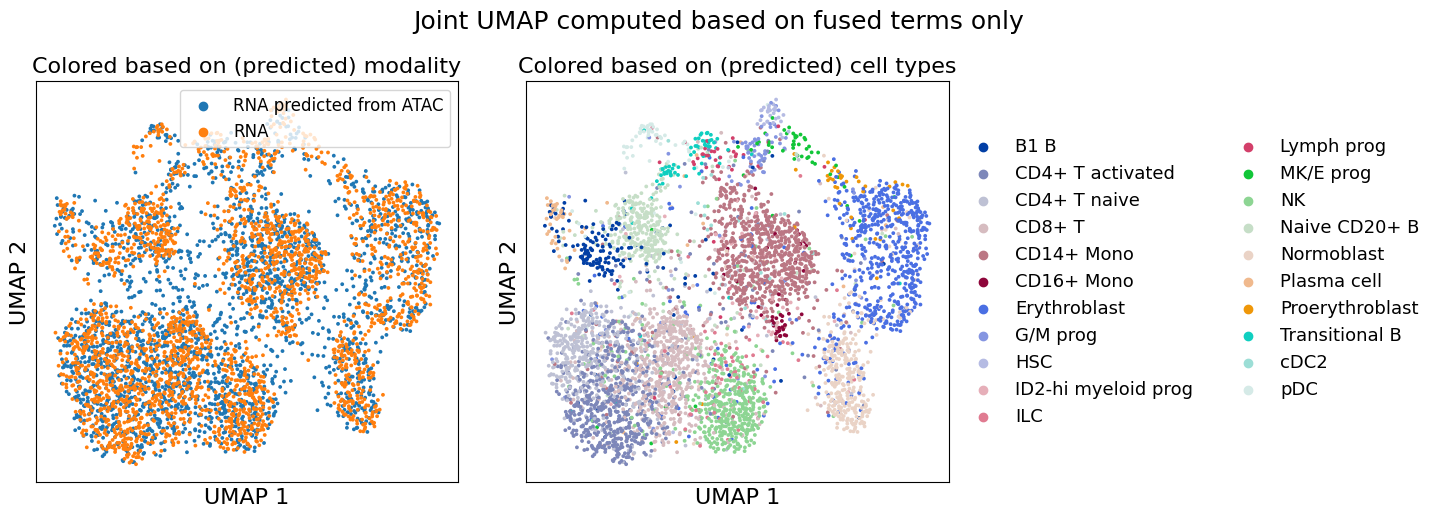

In [17]:
adata_one_sample.obsm["X_translated_1"] = np.concatenate(
    (res_test[0][...,:fused.shape[1]], target_test[...,:fused.shape[1]]), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_1")
sc.tl.umap(adata_one_sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on fused terms only", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

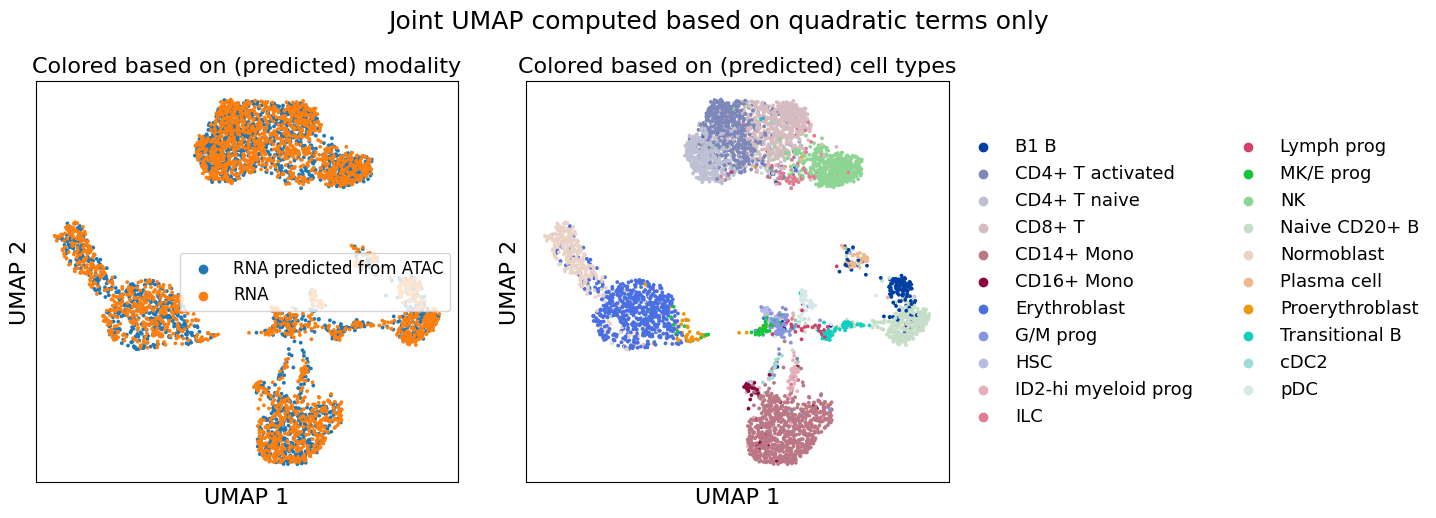

In [18]:
adata_one_sample.obsm["X_translated_2"] = np.concatenate(
    (res_test[0][...,fused.shape[1]:], target_test[...,fused.shape[1]:]), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_2")
sc.tl.umap(adata_one_sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on quadratic terms only", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


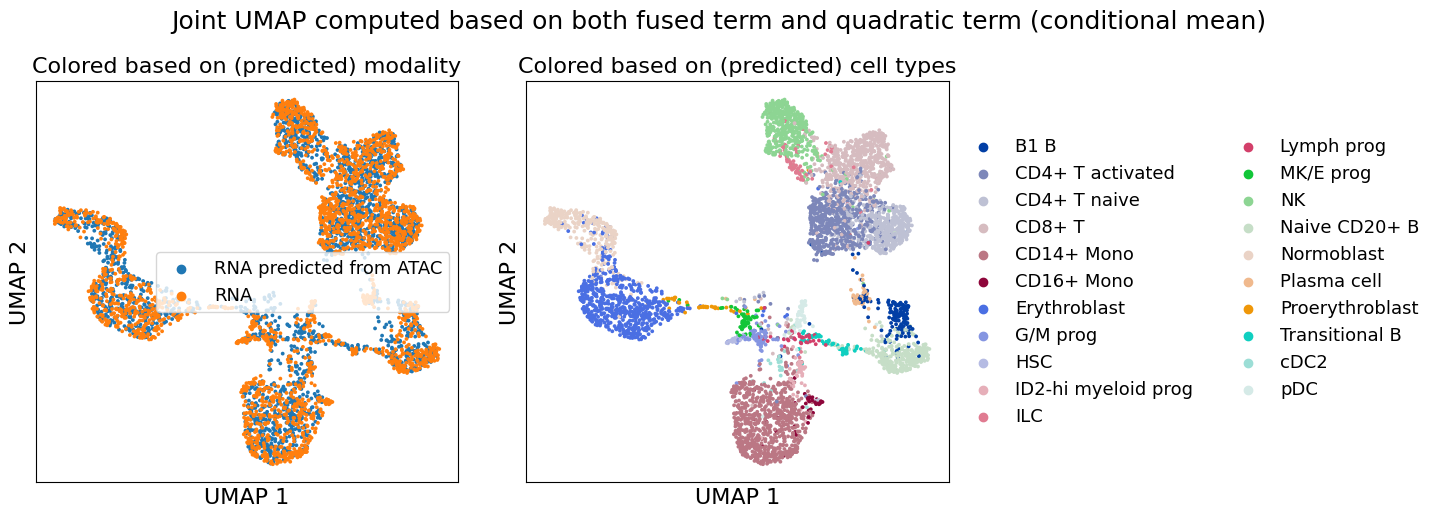

In [19]:
adata_cond_mean = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_cond_mean.obsm["X_translated_0"] = np.concatenate(
    (cond_mean_test, target_test), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_0")
sc.tl.umap(adata_cond_mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term (conditional mean)", size=18, y=0.9)

sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_cond_mean, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

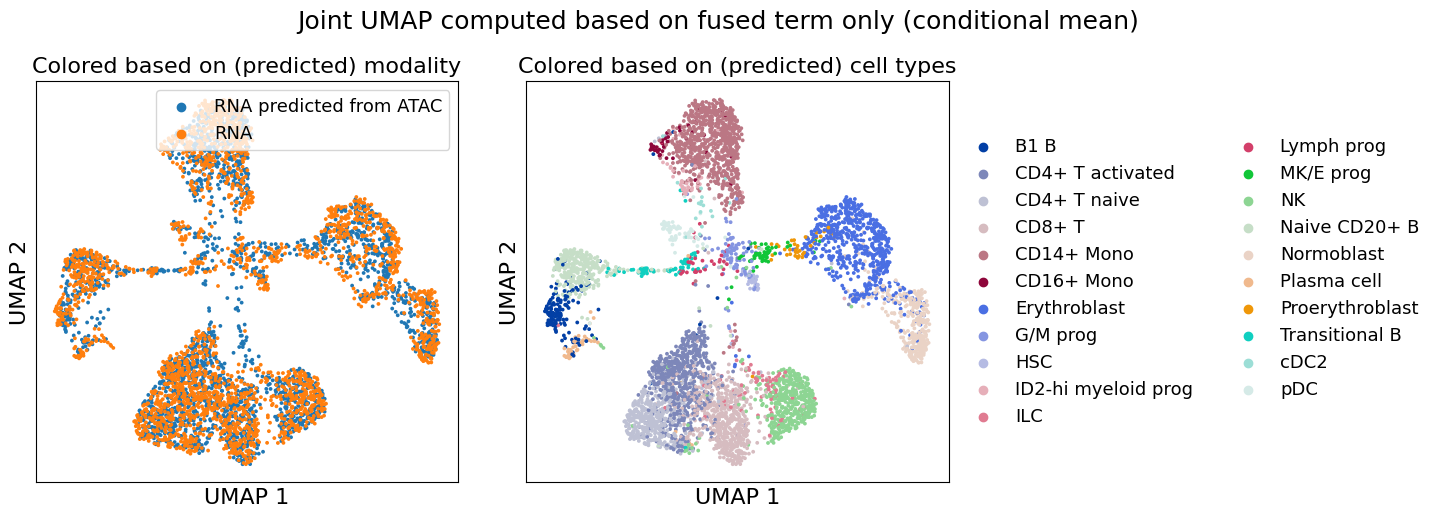

In [20]:
adata_cond_mean.obsm["X_translated_1"] = np.concatenate(
    (cond_mean_test[:, :fused.shape[1]], target_test[:, :fused.shape[1]]), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_1")
sc.tl.umap(adata_cond_mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on fused term only (conditional mean)", size=18, y=0.9)

sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_cond_mean, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13, loc="upper right")
plt.tight_layout(pad=3.0)
plt.show()

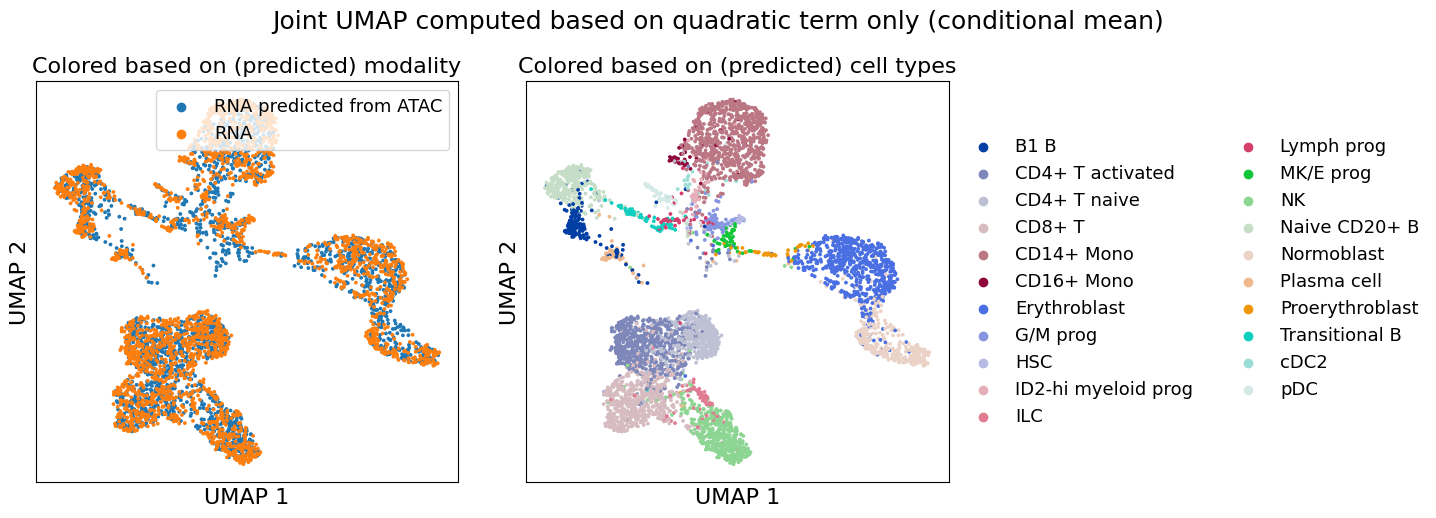

In [21]:
adata_cond_mean.obsm["X_translated_2"] = np.concatenate(
    (cond_mean_test[:, fused.shape[1]:], target_test[:, fused.shape[1]:]), axis=0
)
sc.pp.neighbors(adata_cond_mean, use_rep="X_translated_2")
sc.tl.umap(adata_cond_mean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on quadratic term only (conditional mean)", size=18, y=0.9)

sc.pl.umap(adata_cond_mean, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_cond_mean, color=["cell_type"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13, loc="upper right")
plt.tight_layout(pad=3.0)
plt.show()

## Variances

In [22]:
samples = jnp.array(res_test)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [23]:
adata_source_test.obs["var"] = vars_summed

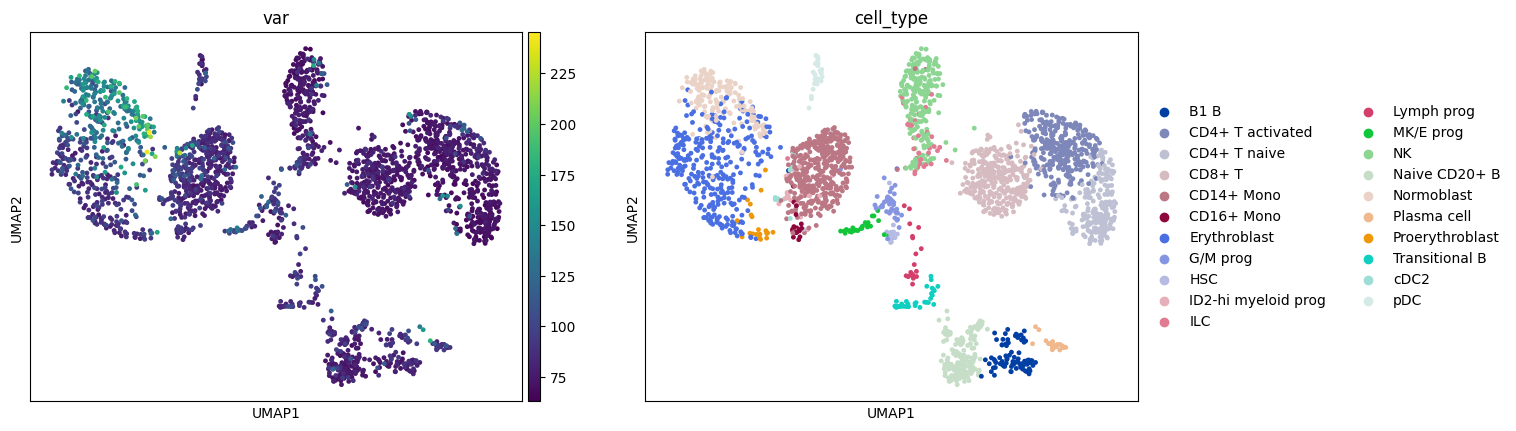

In [24]:
sc.pl.umap(adata_source_test, color=["var", "cell_type"])

In [25]:
adata_source_test.obs[["cell_type", "var"]].groupby("cell_type").mean()

/tmp/ipykernel_1375382/90969336.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_source_test.obs[["cell_type", "var"]].groupby("cell_type").mean()


var
cell_type                      
B1 B                  82.034164
CD4+ T activated      75.989479
CD4+ T naive          73.170609
CD8+ T                74.844437
CD14+ Mono            84.992393
CD16+ Mono            85.630821
Erythroblast         105.283798
G/M prog              92.262634
HSC                   76.511978
ID2-hi myeloid prog   92.054970
ILC                   79.750031
Lymph prog            88.861137
MK/E prog             97.601898
NK                    76.539558
Naive CD20+ B         79.446152
Normoblast           143.697617
Plasma cell           96.070488
Proerythroblast      107.226318
Transitional B        87.423790
cDC2                  96.443657
pDC                   84.354424

# Outer coupling

In [26]:
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=10**8, linear_ot_solver=linear_ot_solver)

genot = GENOT(neural_net, 
                      epsilon=None,
                      scale_cost="mean",
                      input_dim=source_train.shape[1],
                      output_dim=target_train.shape[1],
                      iterations=20_000, 
                      ot_solver=solver,
                      k_noise_per_x=1, 
                      fused_penalty = 1.0, 
                      split_dim=fused.shape[1])

In [27]:
genot(source_train, target_train, 1024, 1024)

100%|██████████| 20000/20000 [04:05<00:00, 81.52it/s]


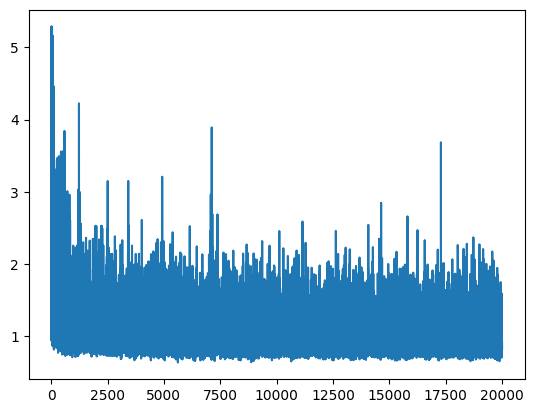

In [28]:
plt.plot(np.arange(len(genot.metrics["loss"])), genot.metrics["loss"])

In [29]:
res_train = [None] * 1
res_test = [None] * 1

for i in range(1):
    res_train[i] = genot.transport(source_train, seed=i)[0][0,...]
    res_test[i] = genot.transport(source_test, seed=i)[0][0,...]

In [30]:
foscttm(res_train[0], target_train)

0.4915

In [31]:
foscttm(res_test[0], target_test)

0.4997

In [32]:
foscttm(cond_mean_train, target_train)

0.0525

In [33]:
foscttm(cond_mean_test, target_test)

0.0537

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


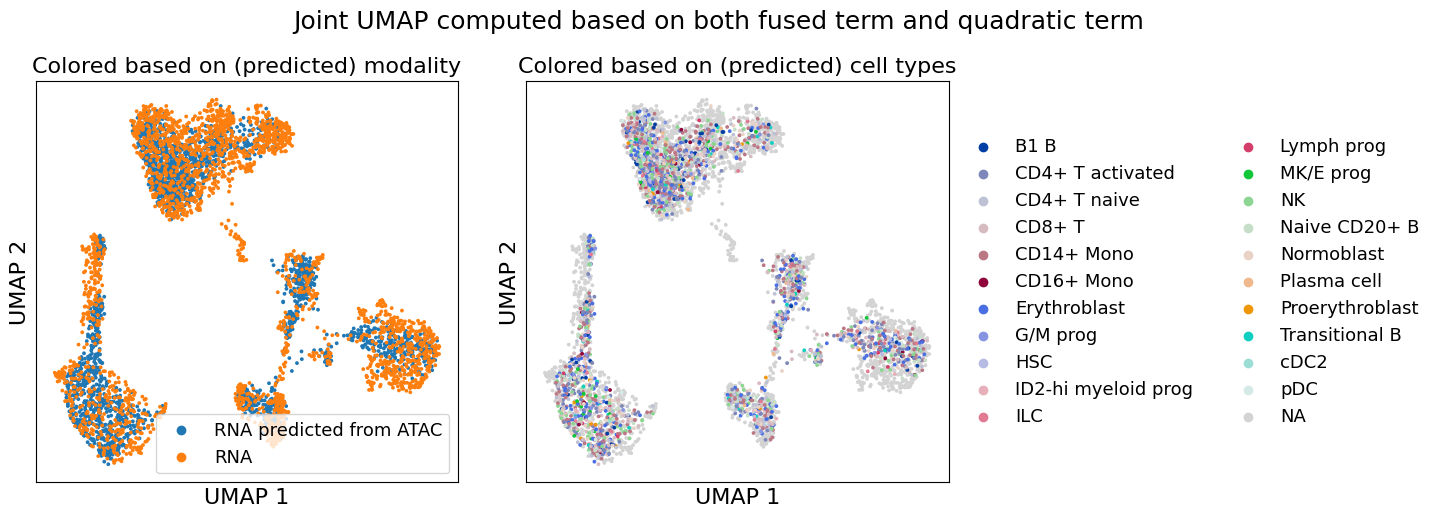

In [34]:
adata_one_sample_outer = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_one_sample_outer.obsm["X_translated_0"] = np.concatenate(
    (res_test[0], target_test), axis=0
)
sc.pp.neighbors(adata_one_sample_outer, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample_outer)

def adapt_cell_type(x):
    if x["batch"] == "RNA":
        return np.nan
    return x["cell_type"]
adata_one_sample_outer.obs["predicted_cell_type_only"] = adata_one_sample_outer.obs.apply(adapt_cell_type, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term", size=18, y=0.9)
sc.pl.umap(adata_one_sample_outer, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample_outer, color=["predicted_cell_type_only"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

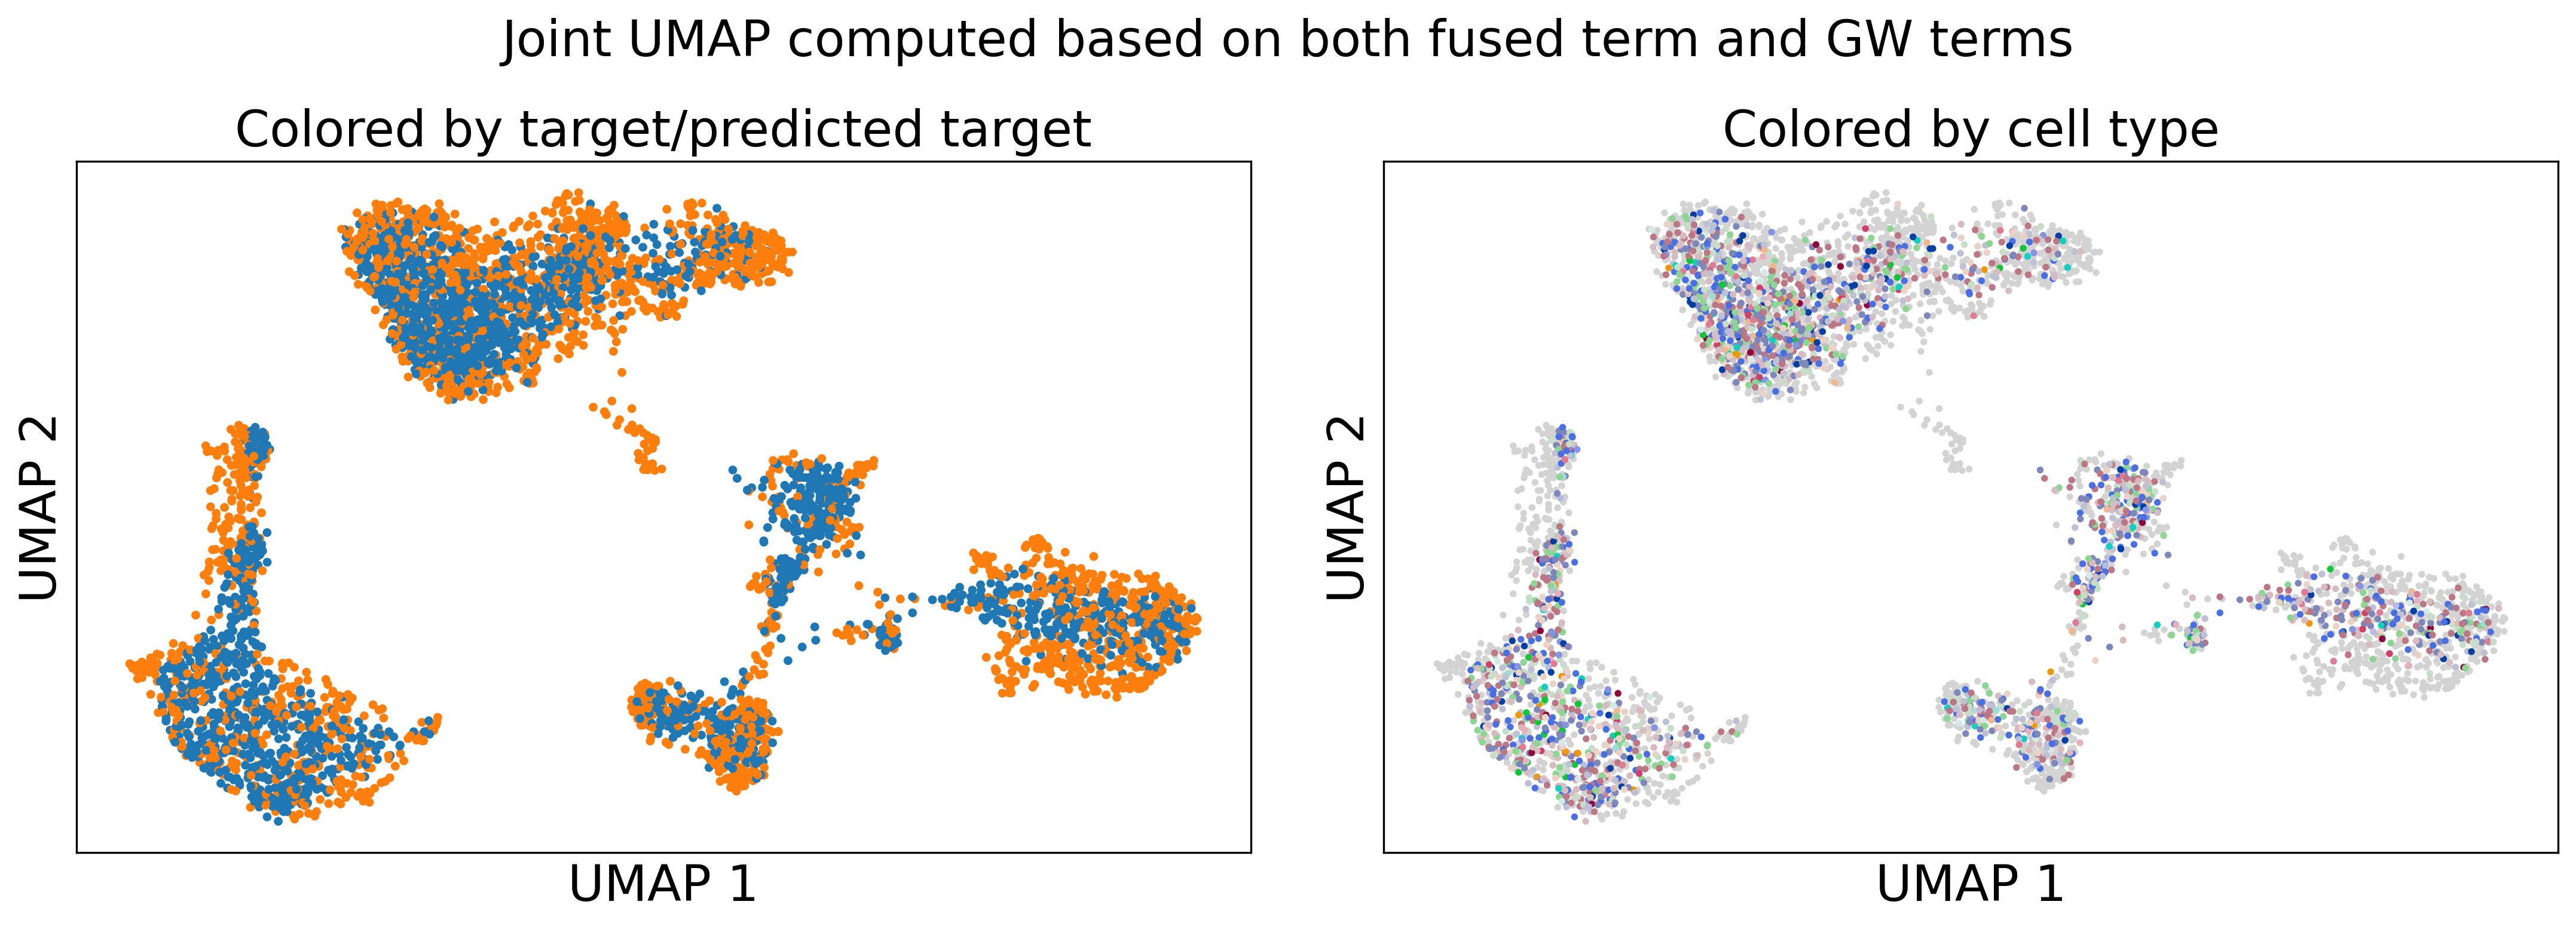

In [35]:
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_one_sample_outer.shape[0])))

sc.pp.neighbors(adata_one_sample_outer, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample_outer)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
fig.suptitle("Joint UMAP computed based on both fused term and GW terms", size=20, y=0.9)
sc.pl.umap(adata_one_sample_outer[random_indices,:], color=["batch"], ax=ax1, show=False, size=50, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored by target/predicted target", fontsize=20)
ax1.set_xlabel('UMAP 1', fontsize=20)
ax1.set_ylabel('UMAP 2', fontsize=20)
sc.pl.umap(adata_one_sample_outer, color=["predicted_cell_type_only"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored by cell type", fontsize=20)
ax2.set_xlabel('UMAP 1', fontsize=20)
ax2.set_ylabel('UMAP 2', fontsize=20)

ax1.get_legend().remove()
ax2.get_legend().remove()
plt.tight_layout(pad=3.0)
plt.show()

# Plots

In [37]:
adata_outer_coupling = adata_one_sample_outer
adata_one_sample.obs["predicted_cell_type_only"] = adata_one_sample.obs.apply(adapt_cell_type, axis=1)

In [38]:
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)

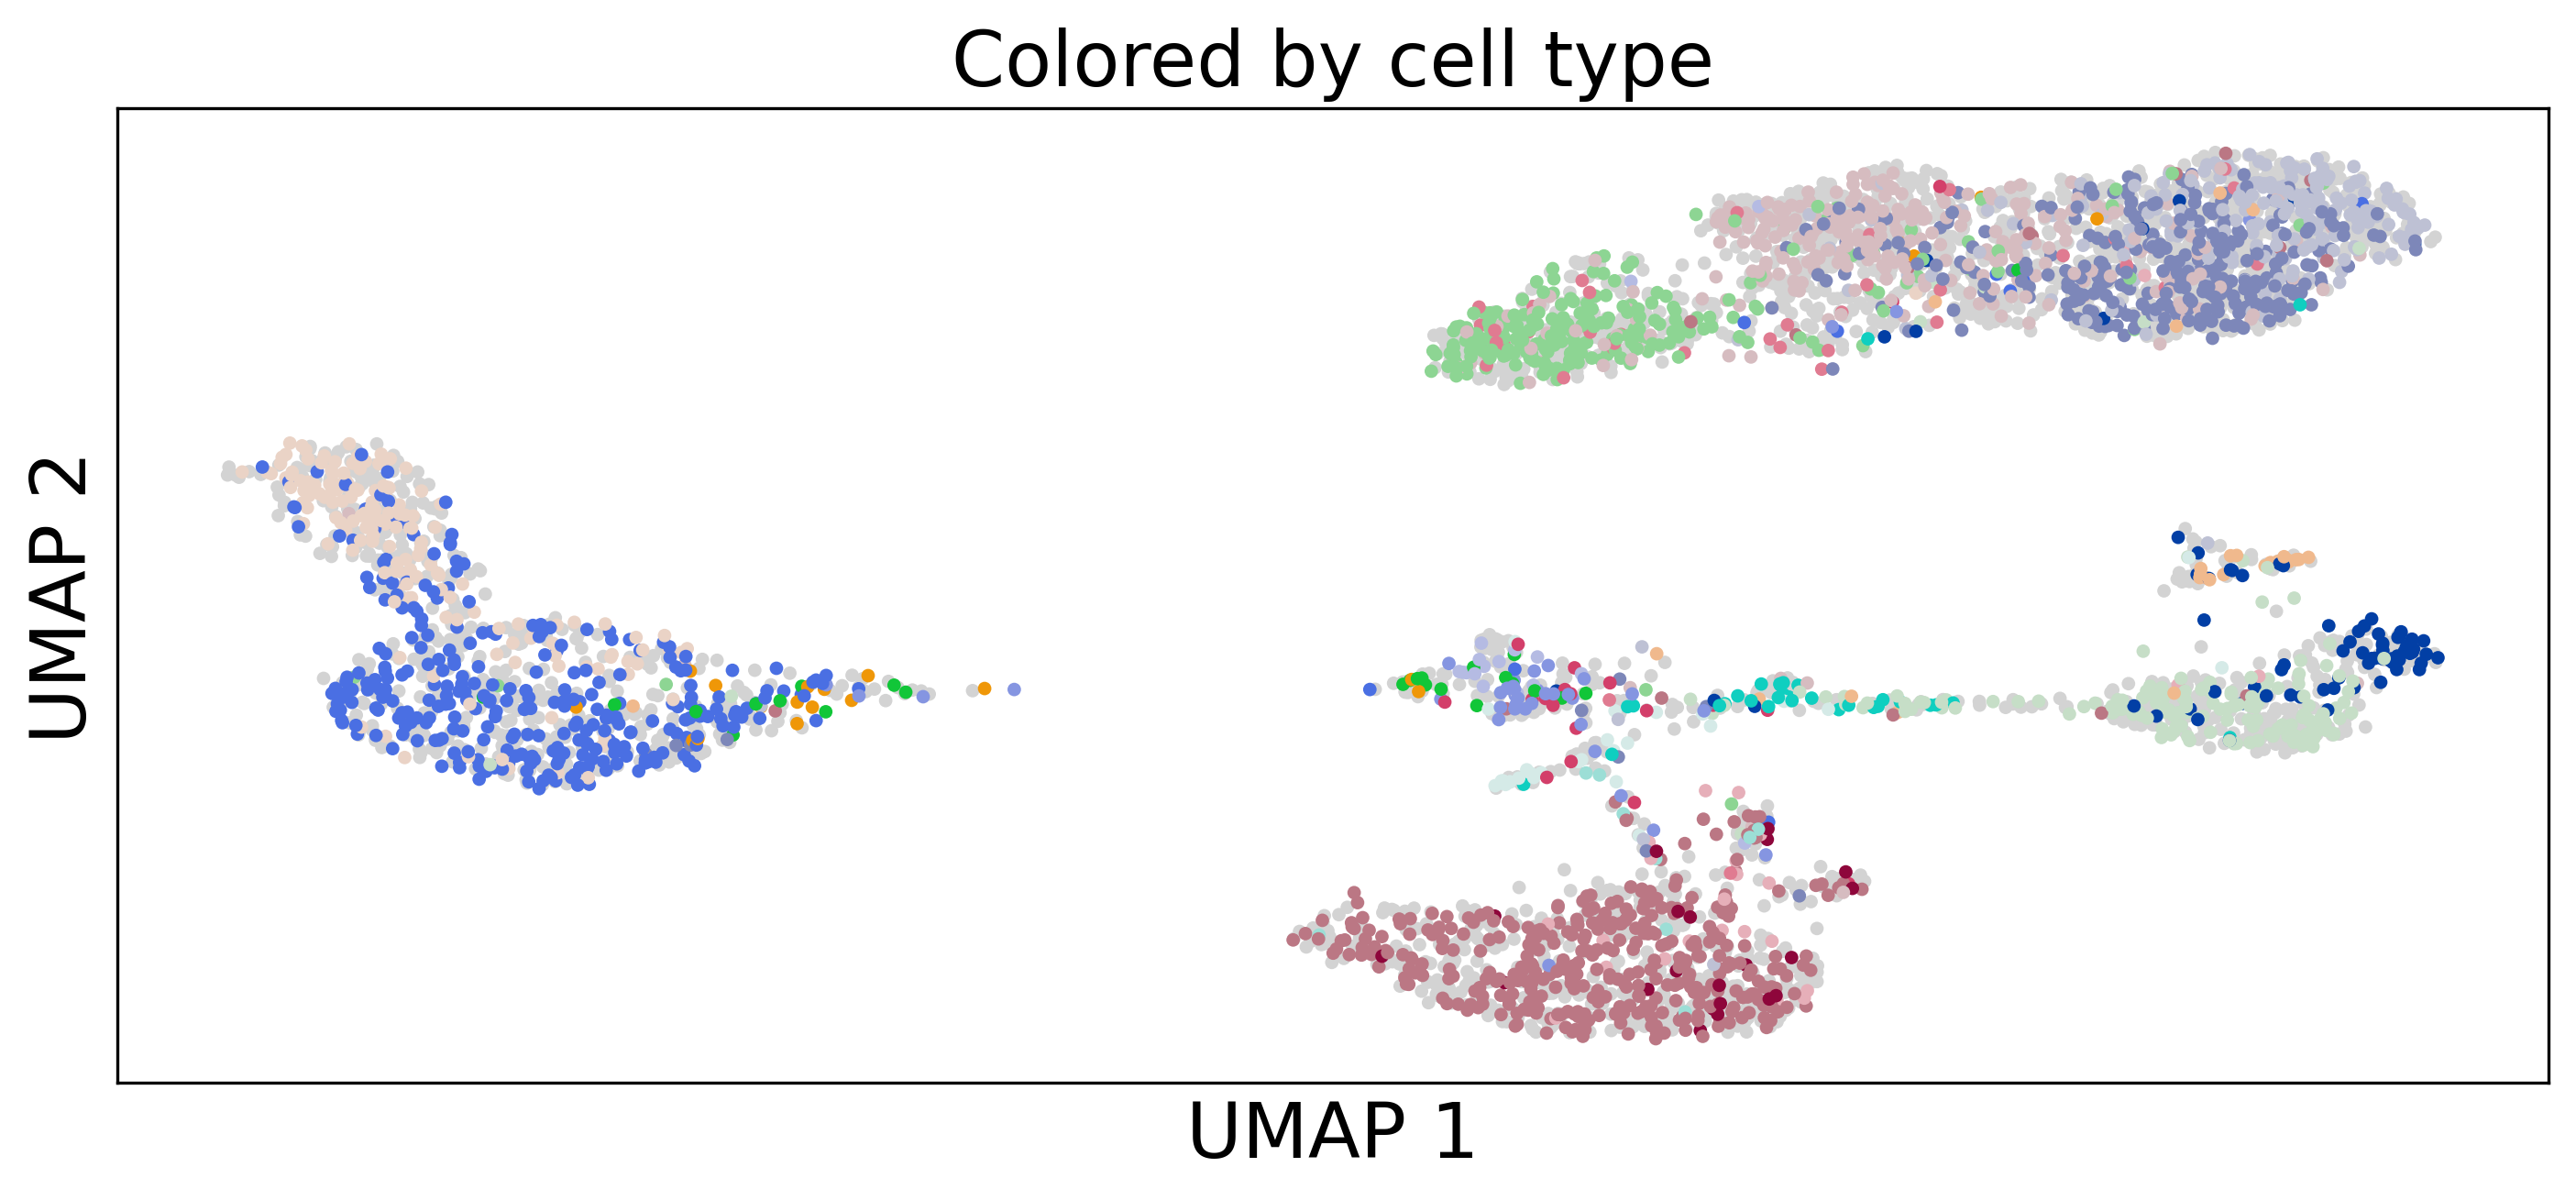

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
sc.pl.umap(adata_one_sample, color=["predicted_cell_type_only"], ax=ax, show=False, size=50, legend_fontsize=13)
ax.set_title("Colored by cell type", fontsize=20)
ax.set_xlabel('UMAP 1', fontsize=20)
ax.set_ylabel('UMAP 2', fontsize=20)

ax.get_legend().remove()
plt.tight_layout(pad=3.0)
plt.show()

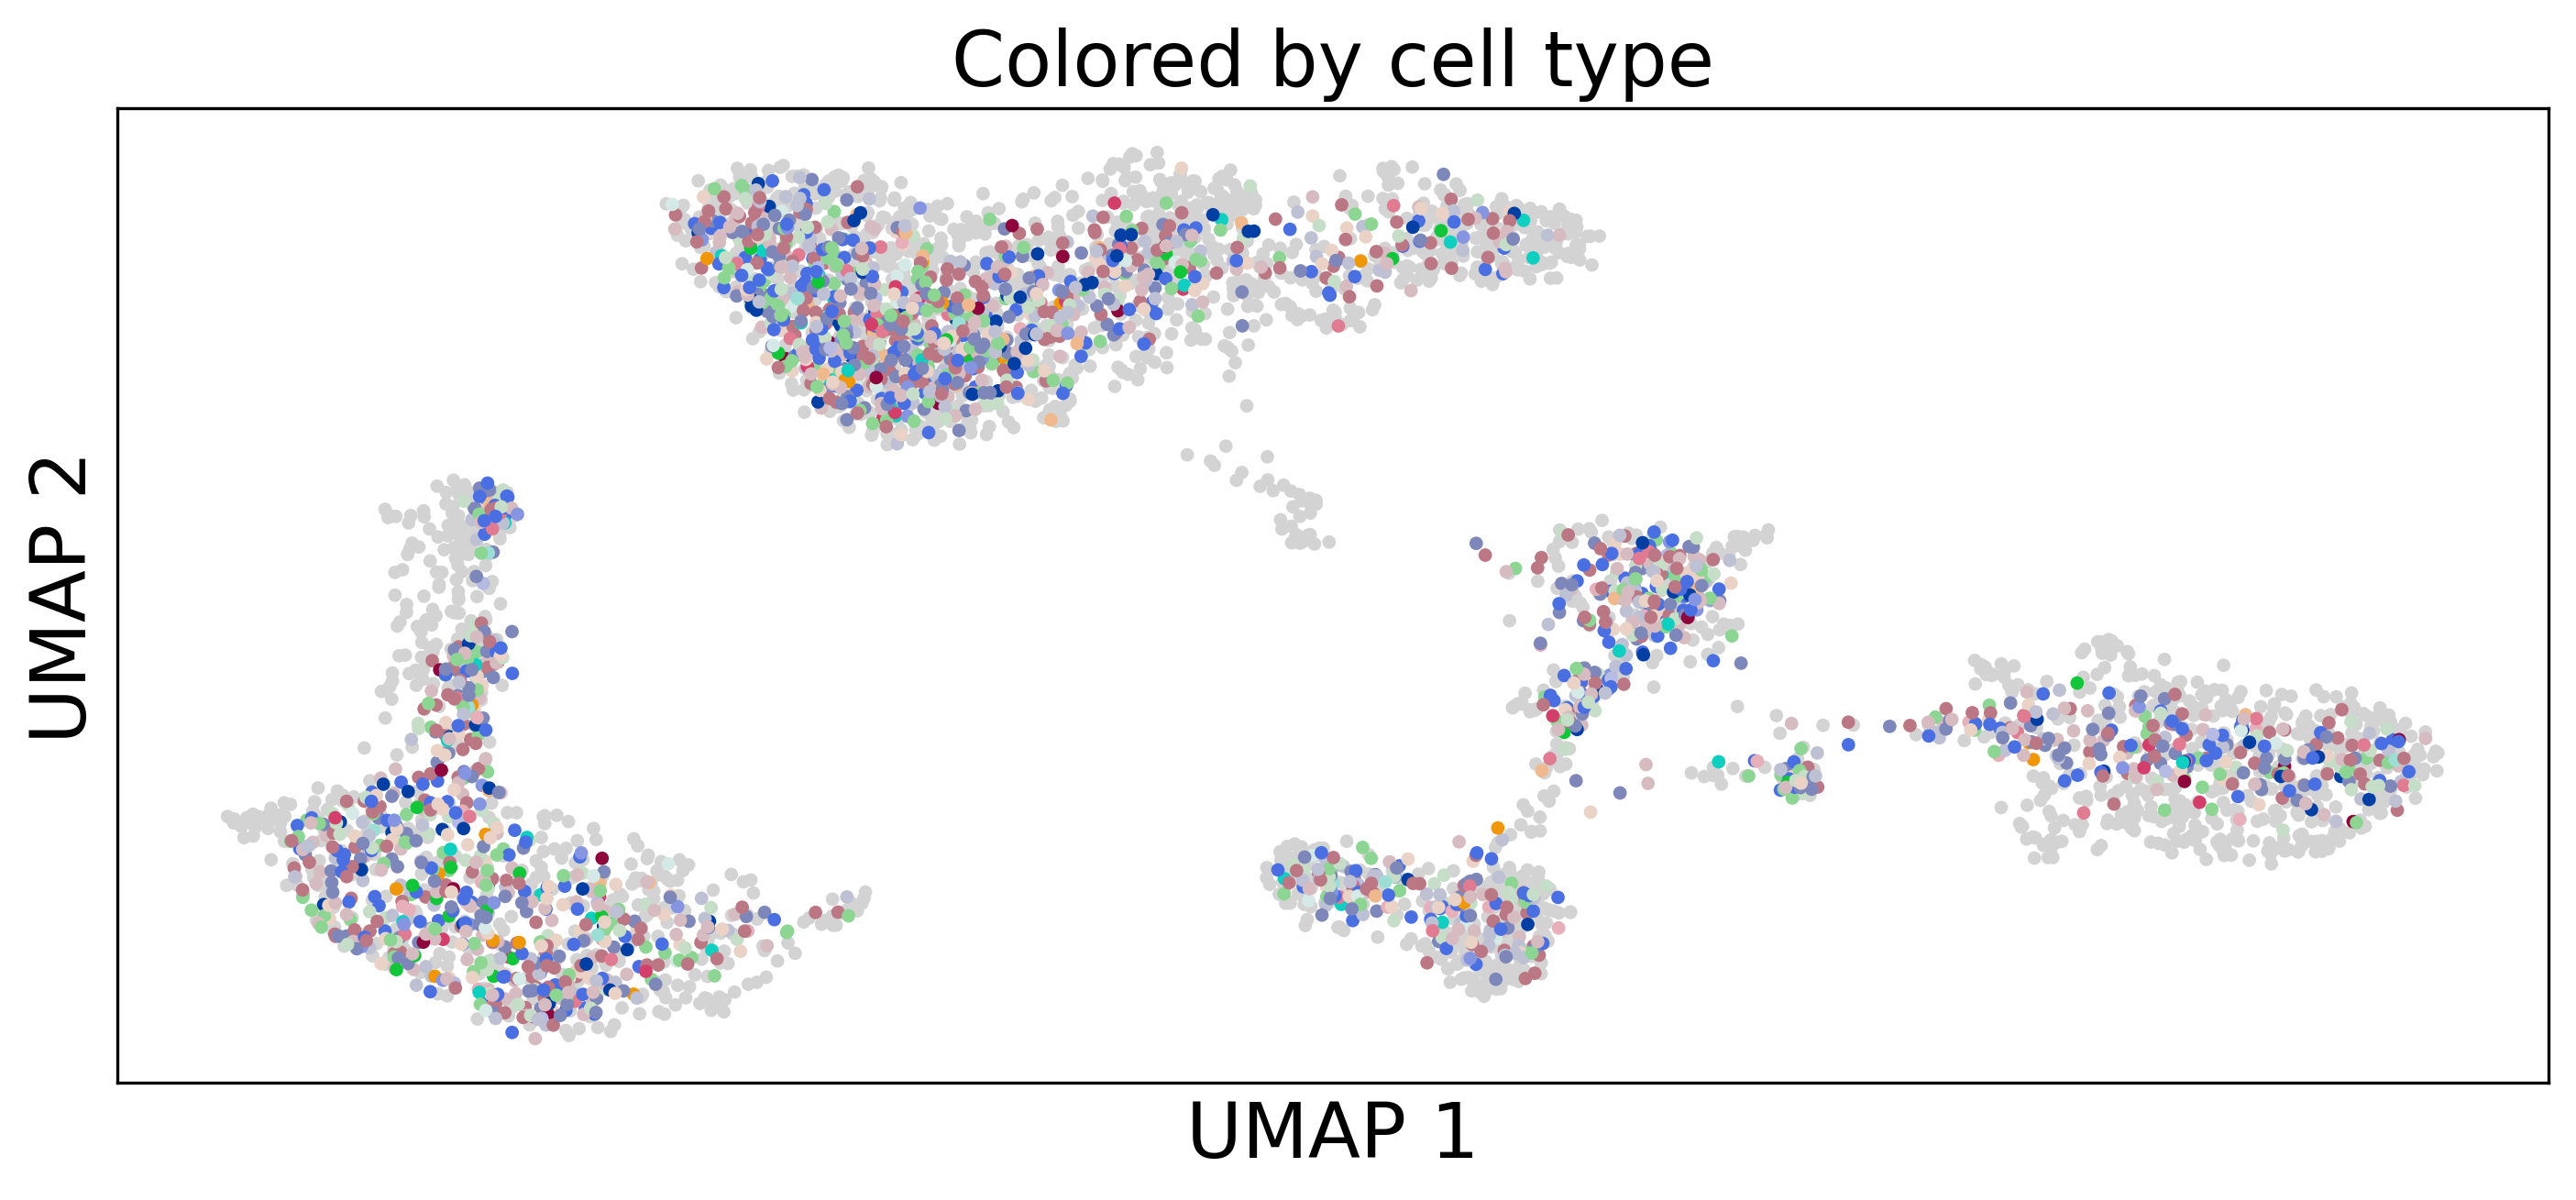

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
sc.pl.umap(adata_outer_coupling, color=["predicted_cell_type_only"], ax=ax, show=False, size=50, legend_fontsize=13)
ax.set_title("Colored by cell type", fontsize=20)
ax.set_xlabel('UMAP 1', fontsize=20)
ax.set_ylabel('UMAP 2', fontsize=20)

ax.get_legend().remove()
plt.tight_layout(pad=3.0)
plt.show()